In [20]:
import pandas as pd
import requests
from datetime import datetime

# Load your subway delay data
df = pd.read_csv(
    "MTA_Subway_Delay-Causing_Incidents__2020-2024_20250717 - MTA_Subway_Delay-Causing_Incidents__2020-2024_20250717.csv",
    parse_dates=["Month"],
)
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={"month": "date", "incidents": "incident_count"}, inplace=True)

# Extract unique dates to fetch weather for
dates = df["date"].dt.date.unique()
start_date = min(dates).isoformat()
end_date = max(dates).isoformat()

# NYC coordinates
lat, lon = 40.7128, -74.0060

# Fetch daily weather data from Open-Meteo
weather_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,"
    f"snowfall_sum,windspeed_10m_max"
    f"&timezone=America%2FNew_York"
    f"&temperature_unit=fahrenheit"
)

print("Fetching daily weather data from Open-Meteo...")
response = requests.get(weather_url)
weather_json = response.json()

weather = pd.DataFrame(weather_json["daily"])
weather["date"] = pd.to_datetime(weather["time"])
weather.drop(columns=["time"], inplace=True)

# --- Fetch monthly average humidity separately ---

# Generate all months in the date range
months = pd.date_range(start=start_date, end=end_date, freq="MS").strftime("%Y-%m-%d").tolist()
humidity_records = []

for month_start in months:
    month_end = (pd.to_datetime(month_start) + pd.offsets.MonthEnd()).strftime("%Y-%m-%d")
    humidity_url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={month_start}&end_date={month_end}"
        f"&hourly=relative_humidity_2m"
        f"&timezone=America/New_York"
    )
    r = requests.get(humidity_url)
    data = r.json()
    humidity_values = data.get("hourly", {}).get("relative_humidity_2m", [])
    if humidity_values:
        avg_humidity = sum(humidity_values) / len(humidity_values)
    else:
        avg_humidity = None
    humidity_records.append({"month": pd.to_datetime(month_start), "avg_humidity": avg_humidity})

humidity_df = pd.DataFrame(humidity_records)

# Merge daily weather with subway delay data on date
merged = pd.merge(df, weather, on="date", how="left")

# Add month column to merged for humidity merge
merged["month"] = merged["date"].dt.to_period("M").dt.to_timestamp()

# Merge monthly humidity on 'month'
merged = pd.merge(merged, humidity_df, on="month", how="left")

# Drop the helper 'month' column if you want
merged.drop(columns=["month"], inplace=True)

# Save or view the result
merged.to_csv("merged_subway_weather_with_humidity.csv", index=False)
print("✅ Merged data with humidity saved to 'merged_subway_weather_with_humidity.csv'")


Fetching daily weather data from Open-Meteo...
✅ Merged data with humidity saved to 'merged_subway_weather_with_humidity.csv'


In [21]:
merged

,date,division,line,day type,reporting category,subcategory,incident_count,temperature_2m_max,temperature_2m_min,precipitation_sum,snowfall_sum,windspeed_10m_max,avg_humidity
0,2024-12-01,A DIVISION,1,1,NaN,NaN,0,36.7,25.2,0.0,0.0,17.9,73.606183
1,2024-12-01,A DIVISION,1,1,Crew Availability,Crew Availability,16,36.7,25.2,0.0,0.0,17.9,73.606183
2,2024-12-01,A DIVISION,1,1,External Factors,External Agency or Utility,0,36.7,25.2,0.0,0.0,17.9,73.606183
3,2024-12-01,A DIVISION,1,1,External Factors,External Debris on Roadbed,2,36.7,25.2,0.0,0.0,17.9,73.606183
4,2024-12-01,A DIVISION,1,1,External Factors,Inclement Weather,0,36.7,25.2,0.0,0.0,17.9,73.606183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72112,2020-01-01,B DIVISION,S Rock,2,Planned ROW Work,Subways Maintenance,1,39.8,30.9,0.0,0.0,28.2,69.090054
72113,2020-01-01,B DIVISION,S Rock,2,Planned ROW Work,Work Equipment,0,39.8,30.9,0.0,0.0,28.2,69.090054
72114,2020-01-01,B DIVISION,S Rock,2,Police & Medical,Persons on Roadbed,0,39.8,30.9,0.0,0.0,28.2,69.090054
72115,2020-01-01,B DIVISION,S Rock,2,Police & Medical,"Public Conduct, Crime, Police Response",1,39.8,30.9,0.0,0.0,28.2,69.090054


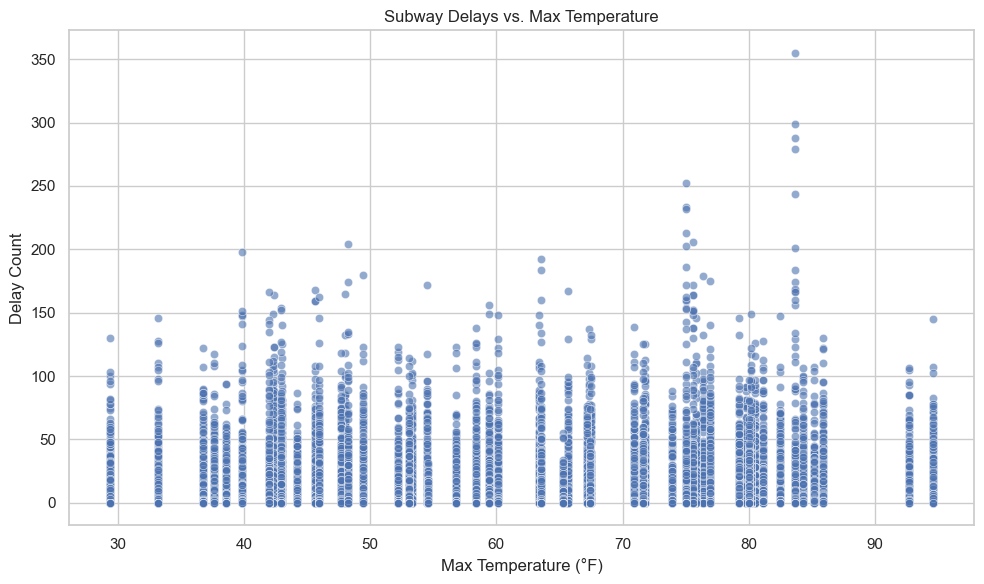

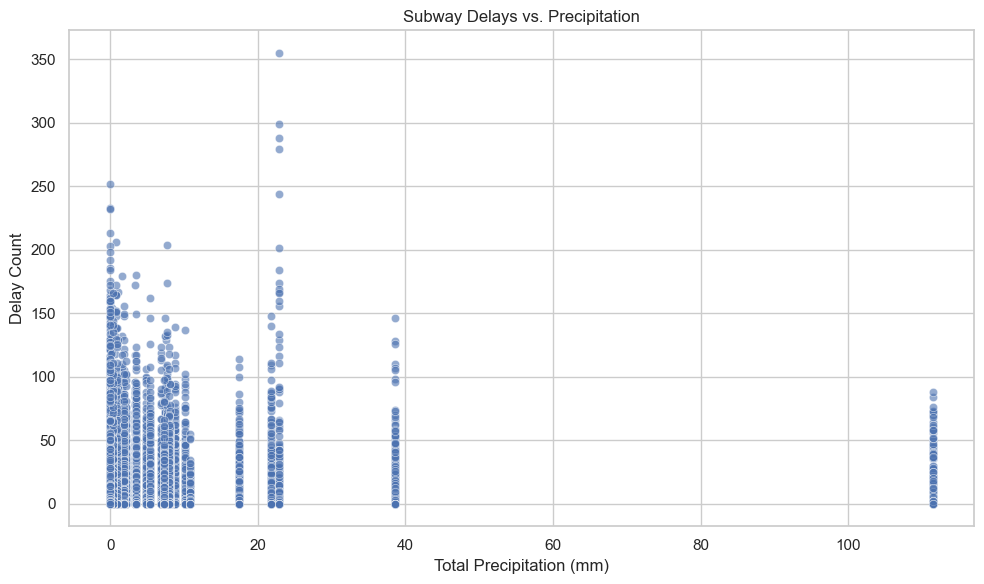

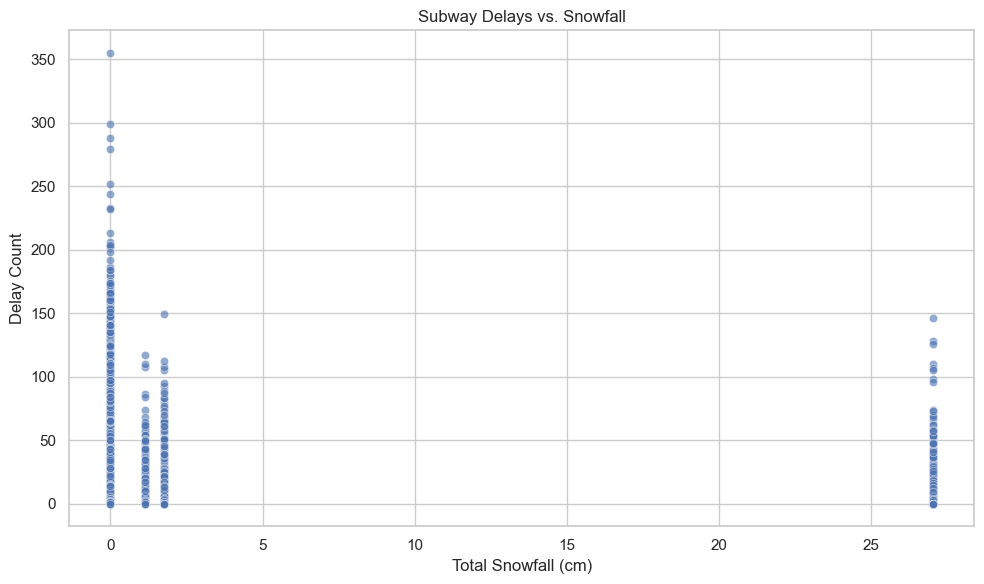

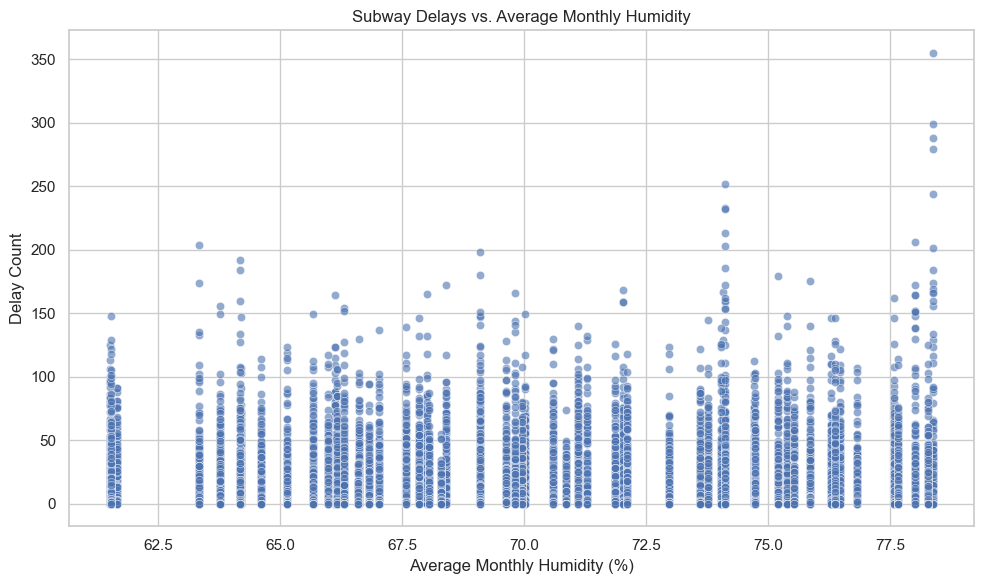

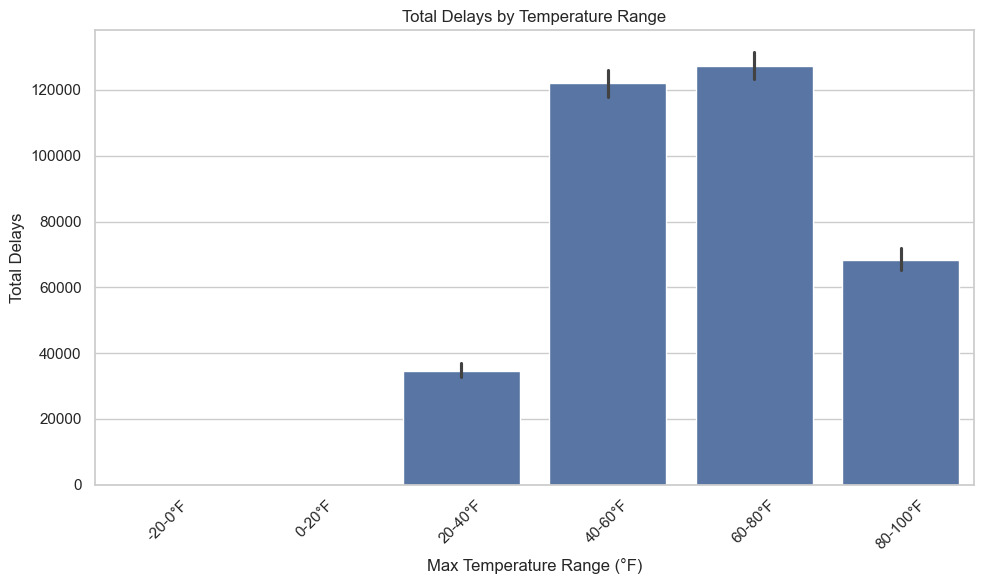

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("merged_subway_weather_with_humidity.csv", parse_dates=["date"])

sns.set(style="whitegrid")

# 1. Delay count vs. temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x="temperature_2m_max", y="incident_count", data=df, alpha=0.6)
plt.title("Subway Delays vs. Max Temperature")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("Delay Count")
plt.tight_layout()
plt.show()

# 2. Delay count vs. precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x="precipitation_sum", y="incident_count", data=df, alpha=0.6)
plt.title("Subway Delays vs. Precipitation")
plt.xlabel("Total Precipitation (mm)")
plt.ylabel("Delay Count")
plt.tight_layout()
plt.show()

# 3. Delay count vs. snowfall
plt.figure(figsize=(10, 6))
sns.scatterplot(x="snowfall_sum", y="incident_count", data=df, alpha=0.6)
plt.title("Subway Delays vs. Snowfall")
plt.xlabel("Total Snowfall (cm)")
plt.ylabel("Delay Count")
plt.tight_layout()
plt.show()

# 4. Delay count vs. average monthly humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x="avg_humidity", y="incident_count", data=df, alpha=0.6)
plt.title("Subway Delays vs. Average Monthly Humidity")
plt.xlabel("Average Monthly Humidity (%)")
plt.ylabel("Delay Count")
plt.tight_layout()
plt.show()

# 5. Total delays by temperature bins
bins = [-20, 0, 20, 40, 60, 80, 100]
labels = ['-20-0°F', '0-20°F', '20-40°F', '40-60°F', '60-80°F', '80-100°F']
df["temp_bin"] = pd.cut(df["temperature_2m_max"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="temp_bin", y="incident_count", data=df, estimator=sum)
plt.title("Total Delays by Temperature Range")
plt.xlabel("Max Temperature Range (°F)")
plt.ylabel("Total Delays")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load your data (make sure date is datetime type)
df = pd.read_csv("merged_subway_weather_with_humidity.csv", parse_dates=["date"])

# Feature engineering
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# For simplicity, encode 'line' as categorical codes
df['line_code'] = df['line'].astype('category').cat.codes

# Select features and target (added 'avg_humidity')
features = ['temperature_2m_max', 'precipitation_sum', 'snowfall_sum', 'avg_humidity', 'month', 'day_of_week', 'is_weekend', 'line_code']
target = 'incident_count'

# Remove rows with missing data (optional)
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

# Split data chronologically (train first 80%, test last 20%)
split_date = df['date'].quantile(0.8)
X_train = X[df['date'] <= split_date]
y_train = y[df['date'] <= split_date]
X_test = X[df['date'] > split_date]
y_test = y[df['date'] > split_date]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 6.609634262513523
RMSE: 13.320851884646181


In [25]:
import pandas as pd

# Load your merged data with humidity (update filename if needed)
df = pd.read_csv("merged_subway_weather_with_humidity.csv", parse_dates=["date"])

# Calculate average daily incidents
mean_incidents = df['incident_count'].mean()
print(f"Average daily incidents: {mean_incidents:.2f}")

# Calculate standard deviation of incidents (variation)
std_incidents = df['incident_count'].std()
print(f"Standard deviation of incidents: {std_incidents:.2f}")

# Baseline MAE: if you predicted mean every day, how wrong would you be on average?
baseline_mae = (df['incident_count'] - mean_incidents).abs().mean()
print(f"Baseline MAE (predict mean daily incidents): {baseline_mae:.2f}")


Average daily incidents: 4.89
Standard deviation of incidents: 13.56
Baseline MAE (predict mean daily incidents): 6.66
